# Time filtering

In [23]:
import numpy as np
import seaborn as sns
import scipy.signal as sig
import matplotlib.pyplot as plt

import panel as pn
from bokeh.resources import INLINE

pn.extension()

sns.set_context('talk')

## Symmetric non-recursive filter

Column
    [0] Column
        [0] DiscreteSlider(formatter='%d', name='i', options=[10, 11, 12, 13, ...], value=20)
        [1] DiscreteSlider(formatter='%d', name='K', options=[3, 5, 7, 9, 11, ...], value=3)
        [2] Select(name='Window', options=['Box', 'Hanning'], value='Box')
    [1] Row
        [0] Matplotlib(Figure, name='interactive00208')
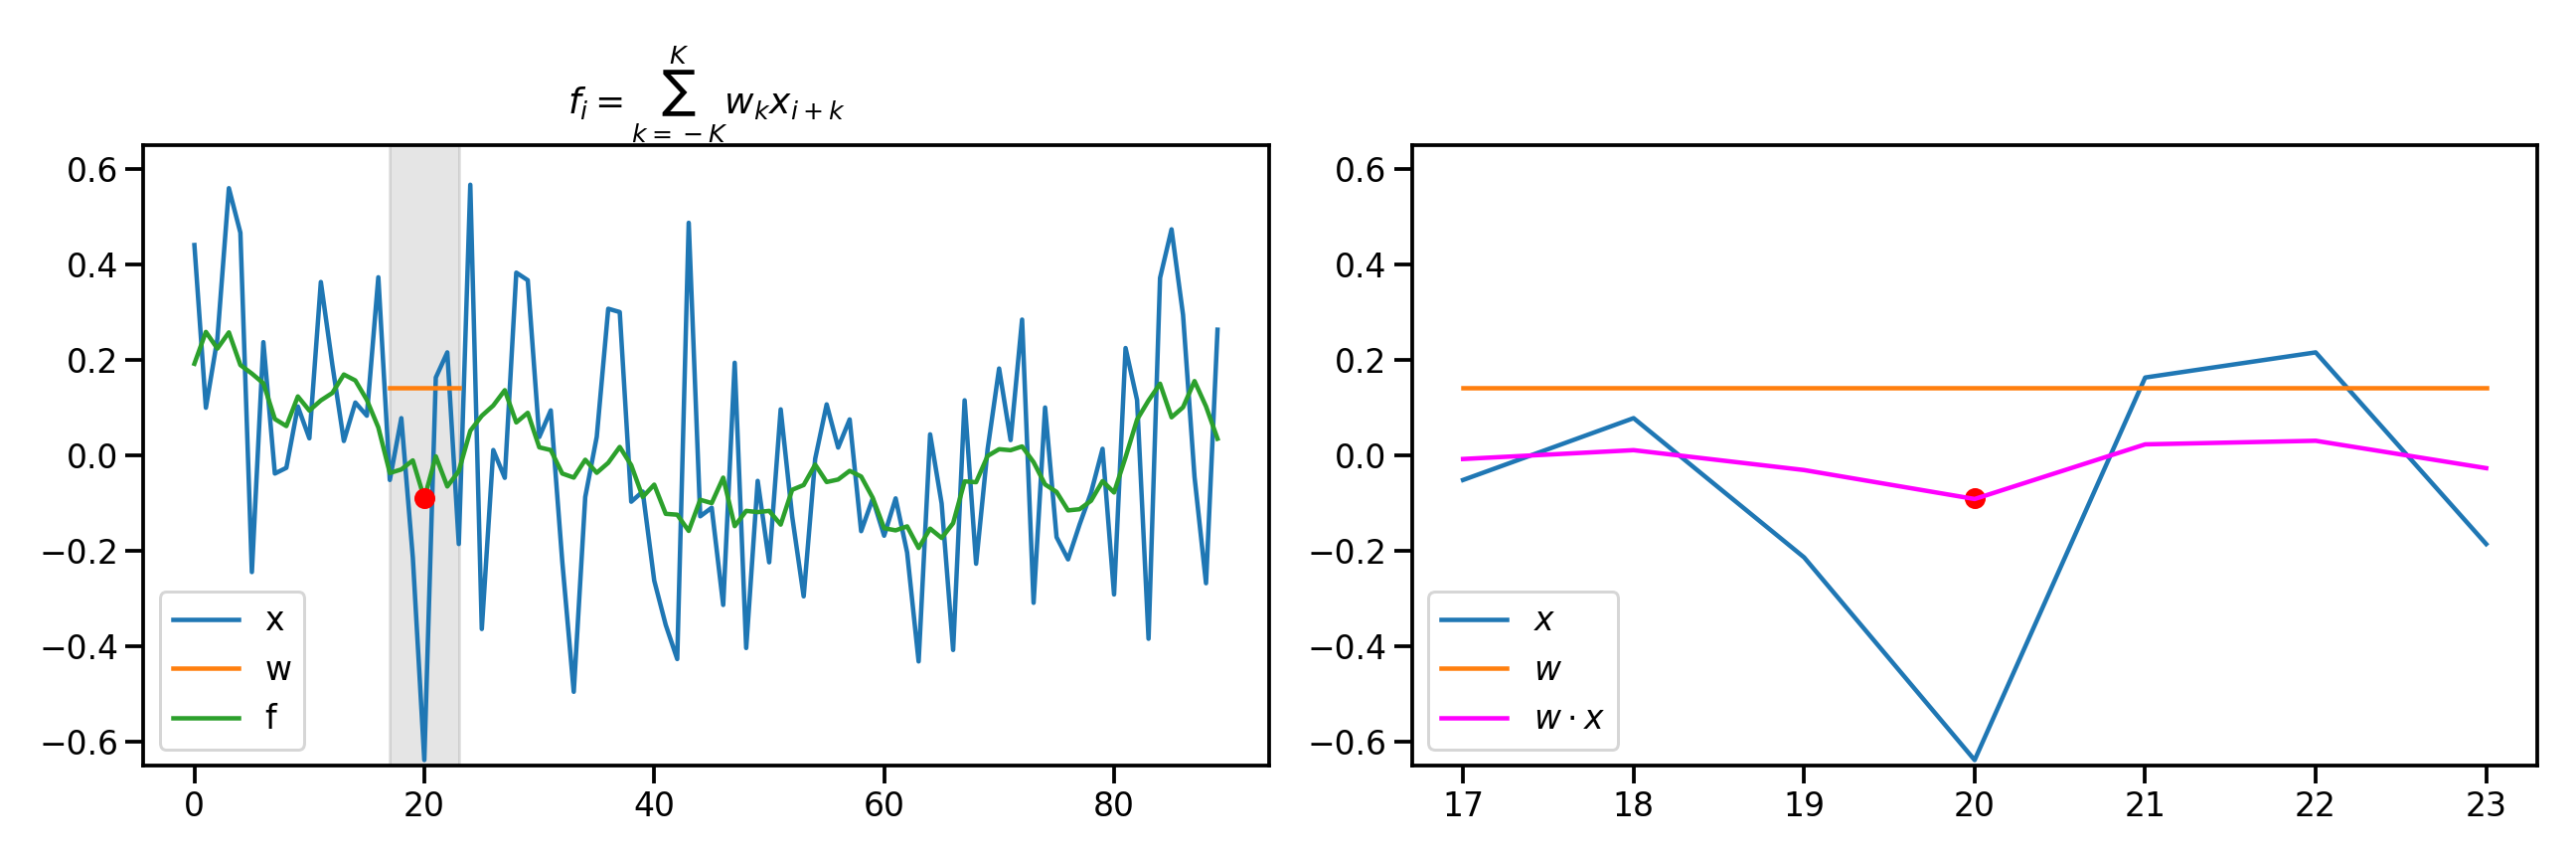

In [24]:
np.random.seed(0)

n = 90 # 800
n_plot=90

t = np.arange(n)
x = .25 * np.random.randn(n)

def plot_convolution(i=20, K=4, window="Box"):
    if window == "Box":
        win_func = np.ones(2 * K + 1)
    elif window == "Hanning":
        win_func = np.hanning(2 * K + 1)
    win_func /= win_func.sum()

    win_slice = slice(i - K, i + K + 1)
    
    w = np.zeros_like(x)
    w[win_slice] = win_func

    filtered = sig.convolve(x, win_func, mode='same')
    weighted_x = (x * w)
    
    
    fig = plt.figure(figsize=(18, 6))
    ax = fig.subplots(1, 2)
    
    ax[0].plot(t, x, label='x')
    ax[0].plot(t[win_slice], win_func, label='w')
    ax[0].plot(t, filtered, label='f')
    ax[0].legend(loc=3)
    ax[0].scatter(t[i], weighted_x.sum(), color='r', zorder=10)
    ax[0].fill_betweenx((-.65, .65), t[win_slice][0], t[win_slice][-1], color="k", alpha=.1)
    ax[0].set_title(r"$f_i = \sum_{k=-K}^{K} w_k x_{i+k}$")
    ax[0].set_ylim(-.65, .65)
    
    ax[1].plot(t[win_slice], x[win_slice], label=r'$x$')
    ax[1].plot(t[win_slice], win_func, label=r'$w$')
    ax[1].plot(t[win_slice], weighted_x[win_slice], label=r"$w\cdot x$", color="magenta")
    ax[1].scatter(t[i], weighted_x.sum(), color='r')
    ax[1].legend(loc=3)
    ax[1].set_ylim(-.65, .65)
    
    plt.tight_layout()
    plt.close(fig)
    return fig
    
p = pn.interact(plot_convolution, K=np.arange(3, 22, 2), i=t[10:-10], window=pn.widgets.Select(name='Window', options=['Box', 'Hanning']));
panel = pn.Column(*p)
panel

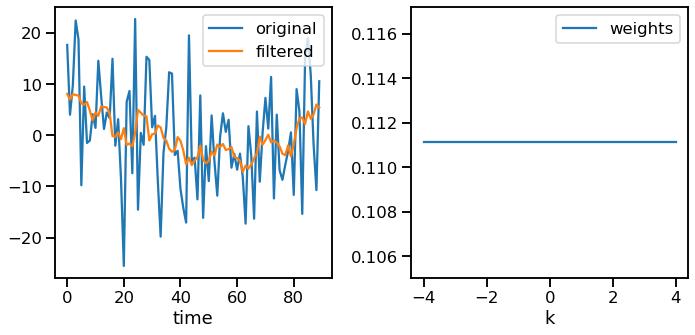

In [3]:
np.random.seed(0)

n = 800
n_plot=90

t = np.arange(n)
x = 10. * np.random.randn(n)

K = 4
w = np.ones(2 * K + 1) / (2 * K + 1)

w_plot = np.zeros(n)
w_plot[20:20+2*K+1] = w

filtered = sig.convolve(x, w, mode='same')

plt.figure(figsize=(10, 5))
plt.subplot(121)
sns.lineplot(t[:n_plot], x[:n_plot], label='original');
sns.lineplot(t[:n_plot], filtered[:n_plot], label='filtered');
plt.xlabel('time');
plt.subplot(122)
sns.lineplot(np.arange(-K, K+1), w, label='weights');
plt.xlabel('k');

plt.tight_layout();
# plt.savefig('../img/8_filtering_1.svg', bbox_inches='tight', pad_inches=.1);

In [3]:
x_transform = np.fft.rfft(x) * 2 / n
freq = np.fft.rfftfreq(n)
w_transform = np.fft.rfft(w, n=n)
filtered_transform = np.fft.rfft(filtered) * 2 / n

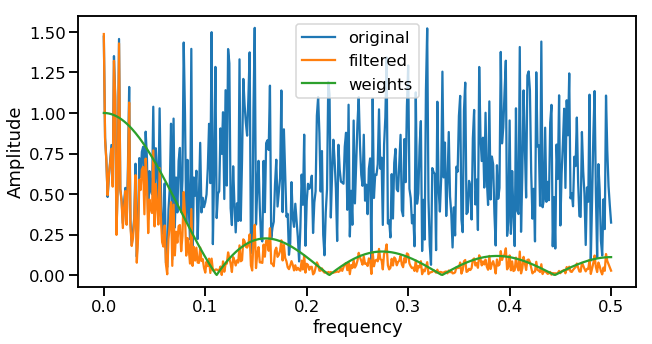

In [4]:
plt.figure(figsize=(10, 5))

sns.lineplot(freq, np.abs(x_transform), label='original')
sns.lineplot(freq, np.abs(filtered_transform), label='filtered')
sns.lineplot(freq, np.abs(w_transform), label='weights')
plt.xlabel('frequency')
plt.ylabel('Amplitude');
plt.savefig('../img/8_filtering_2.svg', bbox_inches='tight', pad_inches=.1);

## The running mean

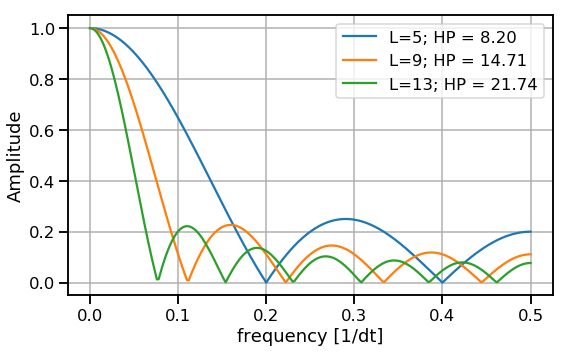

In [30]:
n = 500
fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=True)
axs = [axs]

for k in np.arange(2, 8, 2):
    T = 2 * k + 1
    w = np.ones(T) / T
    freq = np.fft.rfftfreq(n)
    w_transform = np.fft.rfft(w, n=n)
    w_power = w_transform * w_transform.conj()
#     w_transform = np.ones_like(freq)
#     w_transform[1:] = (0j 
#                    + np.sin(2 * np.pi * freq[1:] * T / 2)
#                    / (2 * np.pi * freq[1:] * T / 2))

    plt.sca(axs[0])
    sns.lineplot(freq, np.abs(w_transform), label='L={}; HP = {:.2f}'.format(
        T, 1/freq[np.argmin(np.abs(np.abs(w_transform) - .5))]))
    
#     plt.sca(axs[1])
#     plt.plot(freq, np.angle(w_transform))

axs[0].set(ylabel='Amplitude', xlabel='frequency [1/dt]')
axs[0].grid()
# axs[1].set(ylabel='phase', xlabel='frequency [1/dt]')
# axs[1].grid()
plt.tight_layout();
plt.savefig('../img/8_filtering_3.svg', bbox_inches='tight', pad_inches=.1);

## The Hanning window

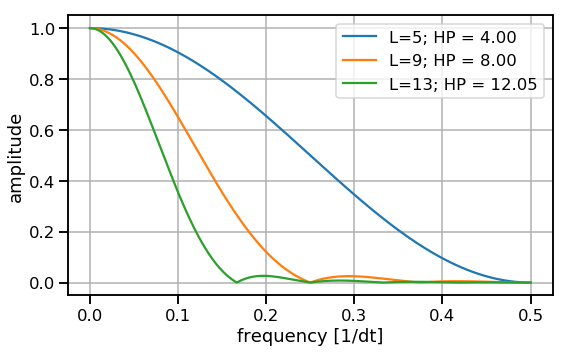

In [32]:
n = 1000
fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=True)
axs = [axs]

for k in np.arange(2, 8, 2):
    T = 2 * k + 1
#     w = np.zeros(n)
#     w[n//2 - k : n//2+k+1] = np.hanning(T)
    w = np.hanning(T)
    w = w / w.sum()
    freq = np.fft.rfftfreq(n)
    w_transform = np.fft.rfft(w, n=n)
#     w_transform = np.ones_like(freq)
#     w_transform = (
#         0j 
#         + .5 * T * np.sinc(freq * T)
#         + .25 * T * np.sinc(T * (freq - 1 / T))
#         + .25 * T * np.sinc(T * (freq + 1 / T))
#     )
    w_transform /= w_transform[0]
    w_power = w_transform * w_transform.conj()

    plt.sca(axs[0])
    sns.lineplot(freq, np.abs(w_transform), label='L={}; HP = {:.2f}'.format(
        T, 1/freq[np.argmin(np.abs(np.abs(w_transform) - .5))]))
    
#     plt.sca(axs[1])
#     plt.plot(freq, np.angle(w_transform), )

axs[0].set(ylabel='amplitude', xlabel='frequency [1/dt]')
axs[0].grid()
# axs[1].set(ylabel='phase')
# axs[1].grid()
plt.tight_layout();
plt.savefig('../img/8_filtering_4.svg', bbox_inches='tight', pad_inches=.1);

## Sharp cutoff lowpass filter

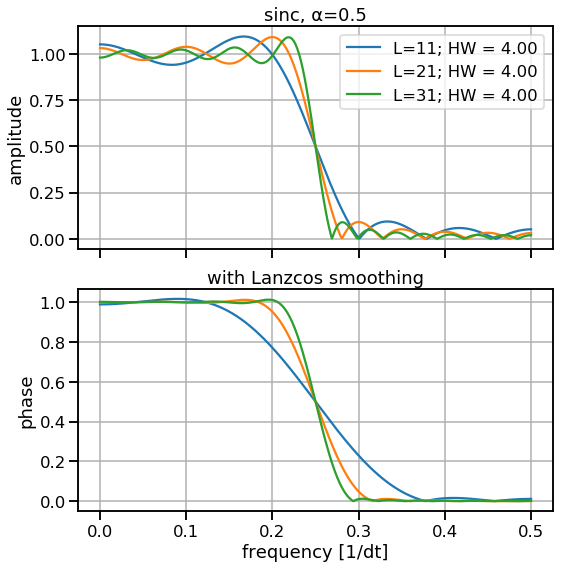

In [38]:
n = 1000
fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

alpha = .5

for k in np.arange(5, 20, 5):
    T = 2 * k + 1
    t = np.arange(-k, k+1)
    w = alpha * np.sinc(alpha * t)
    freq = np.fft.rfftfreq(n)
    w_transform = np.fft.rfft(w, n=n)
    w_transform_2 = np.fft.rfft(w * np.sinc(t / k), n=n)

    plt.sca(axs[0])
    sns.lineplot(freq, np.abs(w_transform), label='L={}; HW = {:.2f}'.format(
        T, 1/freq[np.argmin(np.abs(np.abs(w_transform)-.5))]))
    
    plt.sca(axs[1])
    plt.plot(freq, np.abs(w_transform_2))

axs[0].set(ylabel='amplitude', title="sinc, α=0.5")
axs[0].grid()
axs[1].set(ylabel='phase', title="with Lanzcos smoothing", xlabel='frequency [1/dt]')
axs[1].grid()
plt.tight_layout();
plt.savefig('../img/8_filtering_5.svg', bbox_inches='tight', pad_inches=.1);

## High-pass and band-pass filter

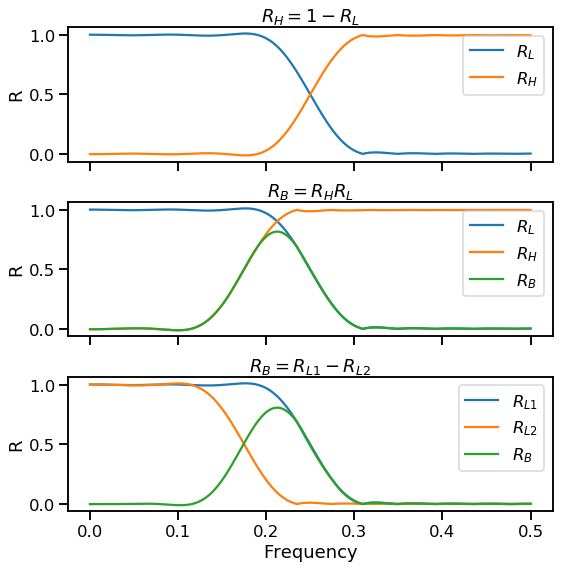

In [48]:
n = 1000
fig, axs = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

alpha_1 = .5
alpha_2 = .35

t = np.arange(-k, k+1)


k = 11
w_1 = alpha_1 * np.sinc(alpha_1 * t) * np.sinc(t / k)
w_2 = alpha_2 * np.sinc(alpha_2 * t) * np.sinc(t / k)

freq = np.fft.rfftfreq(n)
w_transform_1 = np.fft.rfft(w_1, n=n)
r_1 = np.abs(w_transform_1)
w_transform_2 = np.fft.rfft(w_2, n=n)
r_2 = np.abs(w_transform_2)
r_h = 1 - r_1
r_b1 = r_1 * (1-r_2)
r_b2 = r_1 - r_2

plt.sca(axs[0])
sns.lineplot(freq, r_1, label=r'$R_L$')
sns.lineplot(freq, r_h, label=r'$R_H$')
axs[0].set(ylabel="R", title=r'$R_H = 1-R_L$')

plt.sca(axs[1])
sns.lineplot(freq, r_1, label=r'$R_L$')
sns.lineplot(freq, 1-r_2, label=r'$R_H$')
sns.lineplot(freq, r_b1, label=r'$R_B$')
axs[1].set(ylabel="R", title=r'$R_B = R_H R_L$')

plt.sca(axs[2])
sns.lineplot(freq, r_1, label=r'$R_{L1}$')
sns.lineplot(freq, r_2, label=r'$R_{L2}$')
sns.lineplot(freq, r_b2, label=r'$R_B$')
axs[2].set(ylabel="R", title=r'$R_B = R_{L1} - R_{L2}$', xlabel="Frequency")

plt.tight_layout();
plt.savefig('../img/8_filtering_6.svg', bbox_inches='tight', pad_inches=.1);

## Filtering in frequency domain

Column
    [0] Column
        [0] DiscreteSlider(formatter='%d', name='cutoff', options=[0, 1, 2, 3, 4, ...], value=10)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00233')
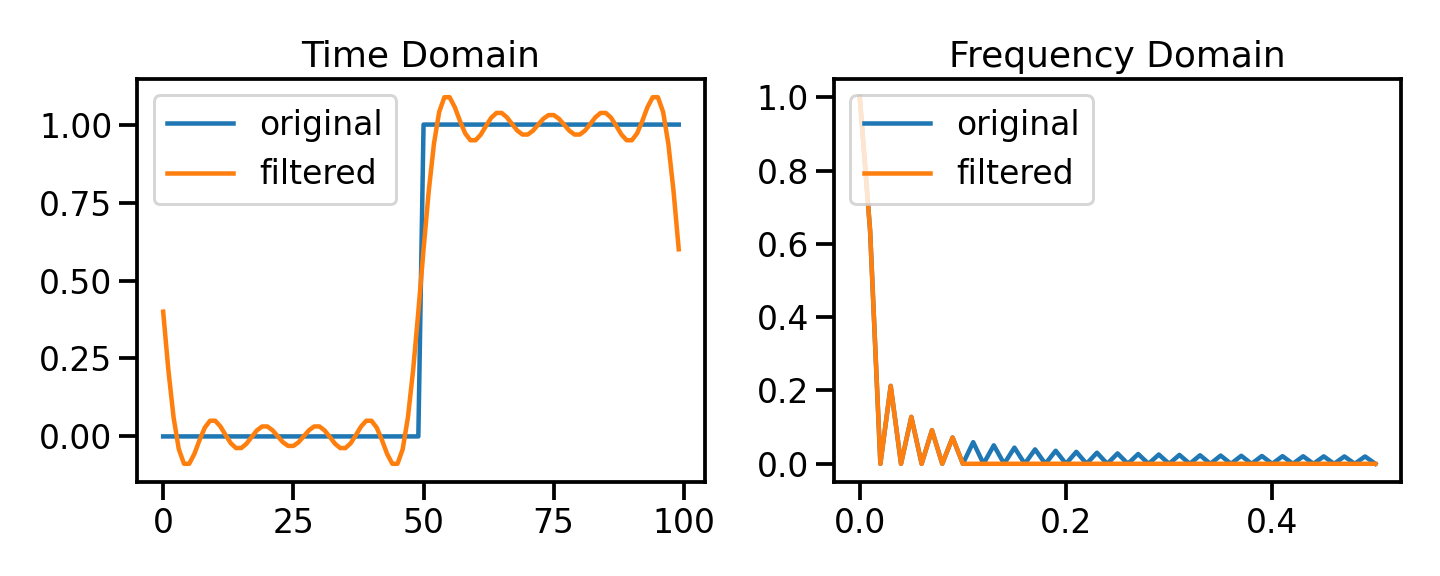

In [26]:
N = 100

sig = np.zeros(N)
sig[N//2:] = 1.

fft = np.fft.rfft(sig)
freq = np.fft.rfftfreq(N)

def plot_filter(cutoff=10):
    fft_cut = fft.copy()
    fft_cut[cutoff:] = 0.
    
    sig_cut = np.fft.irfft(fft_cut)

    fig = plt.figure(figsize=(10, 4))
    ax = fig.subplots(1, 2)
    
    ax[0].plot(sig, label="original")
    ax[0].plot(sig_cut, label='filtered')
    ax[0].legend(loc=2)
    ax[0].set_title("Time Domain")
    
    ax[1].plot(freq, np.abs(fft) * 2 / N, label="original")
    ax[1].plot(freq, np.abs(fft_cut) * 2 / N, label="filtered")
    ax[1].legend(loc=2)
    ax[1].set_title("Frequency Domain")
    
    plt.tight_layout()
    plt.close(fig)
    return fig

p = pn.interact(plot_filter, cutoff=np.arange(N//2 + 1));
panel = pn.Column(*p)
panel